# Forecasting

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults

import warnings
warnings.filterwarnings('ignore')

## Business Problem

In [2]:
Airlines=pd.read_excel("Airlines+Data.xlsx")

In [3]:
Airlines.head()

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121


In [4]:
Airlines["Date"] = pd.to_datetime(Airlines.Month,format="%y-%b-%d")
#look for c standard format codes

# Extracting Day, weekday name, month name, year from the Date column using 
# Date functions from pandas 
Airlines["month"] = Airlines.Date.dt.strftime("%b") # month extraction
Airlines["year"] = Airlines.Date.dt.strftime("%Y") # year extraction

Airlines["Day"] = Airlines.Date.dt.strftime("%d") # Day extraction
Airlines["week day"] = Airlines.Date.dt.strftime("%a") # weekday extraction

In [5]:
Airlines.head()

,Month,Passengers,Date,month,year,Day,week day
0,1995-01-01,112,1995-01-01,Jan,1995,01,Sun
1,1995-02-01,118,1995-02-01,Feb,1995,01,Wed
2,1995-03-01,132,1995-03-01,Mar,1995,01,Wed
3,1995-04-01,129,1995-04-01,Apr,1995,01,Sat
4,1995-05-01,121,1995-05-01,May,1995,01,Mon


In [6]:
Airlines.drop(['Month','Date','Day','week day'],axis=1,inplace=True)

In [7]:
Airlines.head()

,Passengers,month,year
0,112,Jan,1995
1,118,Feb,1995
2,132,Mar,1995
3,129,Apr,1995
4,121,May,1995


In [8]:
Airlines.year.value_counts()

year
1995    12
1996    12
1997    12
1998    12
1999    12
2000    12
2001    12
2002    12
Name: count, dtype: int64

In [9]:
Airlines.shape

(96, 3)

In [10]:
Airlines.columns

Index(['Passengers', 'month', 'year'], dtype='object')

In [11]:
Airlines.isna().sum()

Passengers    0
month         0
year          0
dtype: int64

In [12]:
Airlines[Airlines.duplicated()]

,Passengers,month,year


In [13]:
Airlines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Passengers  96 non-null     int64 
 1   month       96 non-null     object
 2   year        96 non-null     object
dtypes: int64(1), object(2)
memory usage: 2.4+ KB


In [14]:
Airlines.describe().T

,count,mean,std,min,25%,50%,75%,max
Passengers,96.0,213.708333,71.918216,104.0,156.0,200.0,264.75,413.0


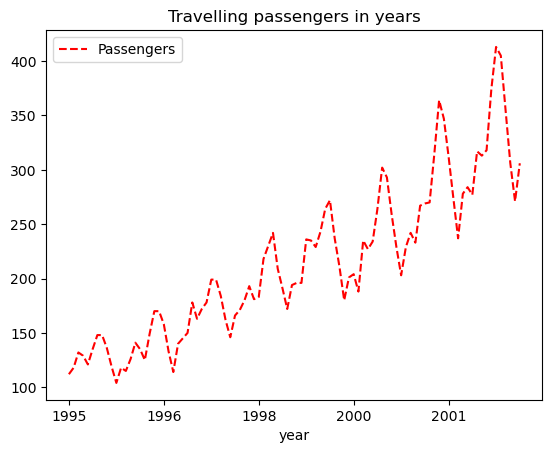

In [15]:
Airlines.plot(x='year',y='Passengers',color='r',label='Passengers',linestyle='--')
plt.title('Travelling passengers in years');

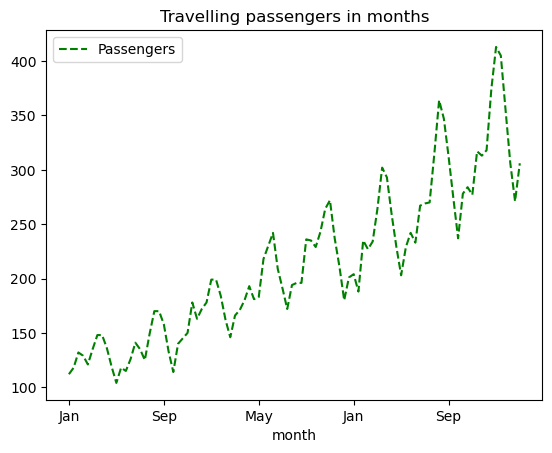

In [46]:
Airlines.plot(x='month',y='Passengers',color='g',label='Passengers',linestyle='--')
plt.title('Travelling passengers in months');

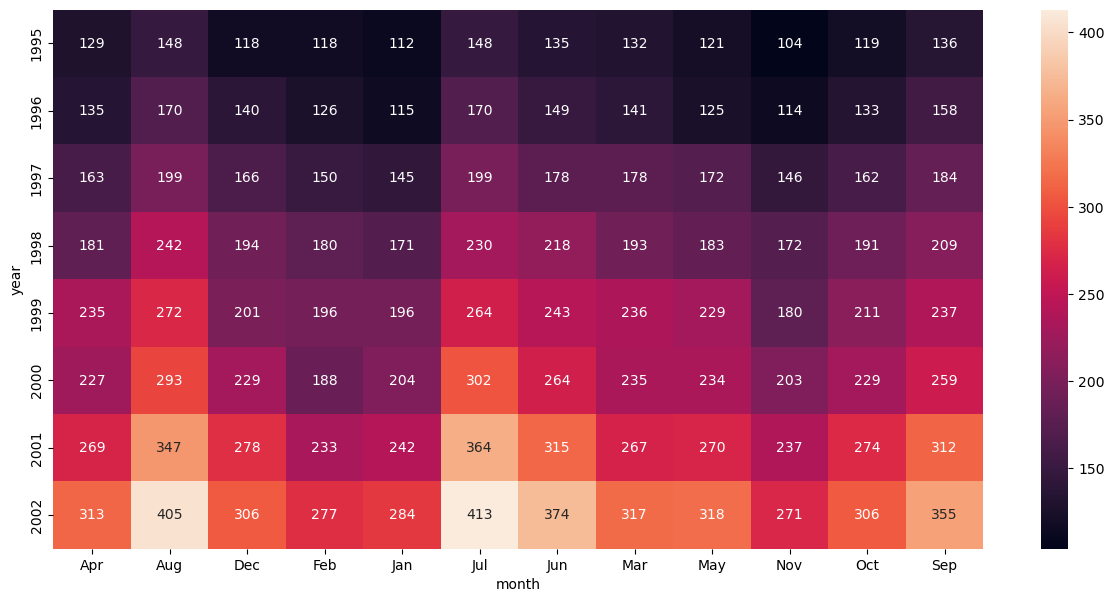

In [16]:
plt.figure(figsize=(15,7))
heatmap_air = pd.pivot_table(data=Airlines,values='Passengers',index='year',columns='month')
sns.heatmap(heatmap_air,annot=True,fmt='g');

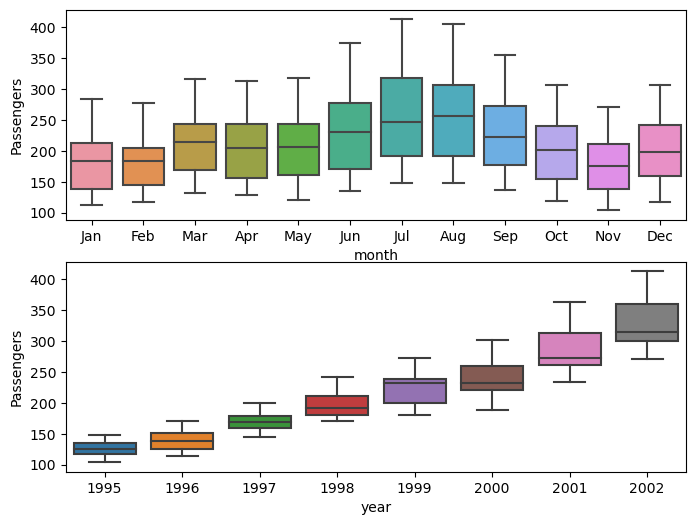

In [17]:
# Boxplot for ever
plt.figure(figsize=(8,6))
plt.subplot(211)
sns.boxplot(x="month",y="Passengers",data=Airlines)
plt.subplot(212)
sns.boxplot(x="year",y="Passengers",data=Airlines);

In [18]:
Month_Dummies = pd.DataFrame(pd.get_dummies(Airlines['month'],dtype='float'))
airlines = pd.concat([Airlines,Month_Dummies],axis = 1)

In [19]:
airlines.head()

,Passengers,month,year,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,112,Jan,1995,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,118,Feb,1995,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,132,Mar,1995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,129,Apr,1995,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,121,May,1995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [20]:
airlines["t"] = np.arange(1,97)
airlines["t_squared"] = airlines["t"]*airlines["t"]
airlines["Log_Passengers"] = np.log(airlines["Passengers"])

In [21]:
airlines.head()

,Passengers,month,year,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,t,t_squared,Log_Passengers
0,112,Jan,1995,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,4.718499
1,118,Feb,1995,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,4,4.770685
2,132,Mar,1995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3,9,4.882802
3,129,Apr,1995,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,16,4.859812
4,121,May,1995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5,25,4.795791


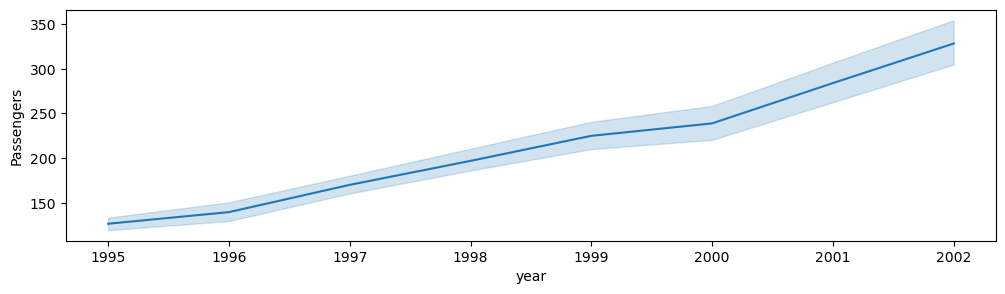

In [22]:
plt.figure(figsize=(12,3))
sns.lineplot(x="year",y="Passengers",data=airlines);

## Moving Average

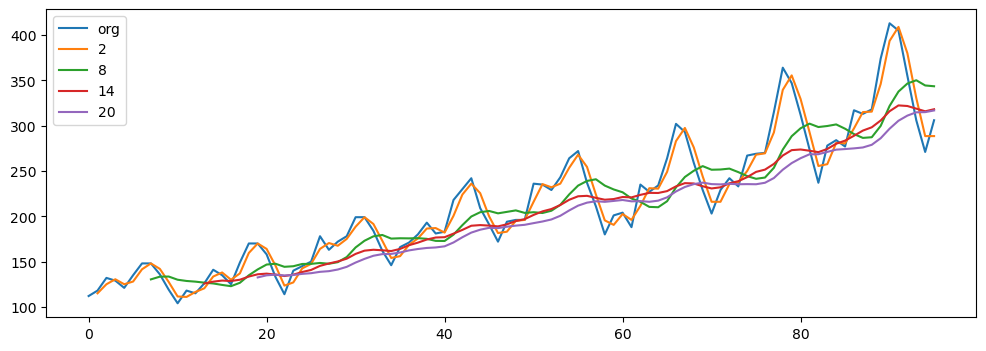

In [23]:
plt.figure(figsize=(12,4))
airlines.Passengers.plot(label="org")
for i in range(2,24,6):
    airlines["Passengers"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best');

## Decomposition

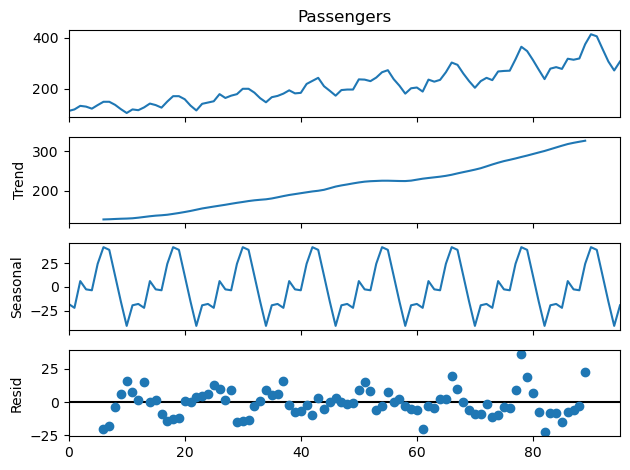

In [72]:
decompose = seasonal_decompose(airlines.Passengers,period=12)
decompose.plot()
plt.show()

## Acf and Pacf Plots

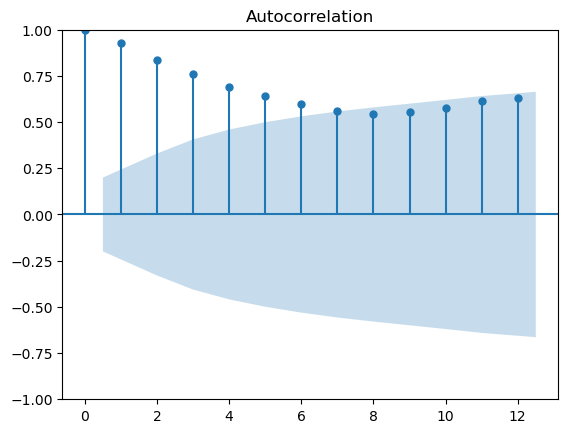

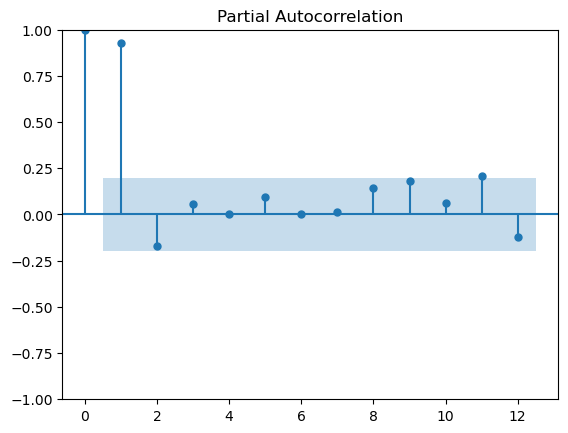

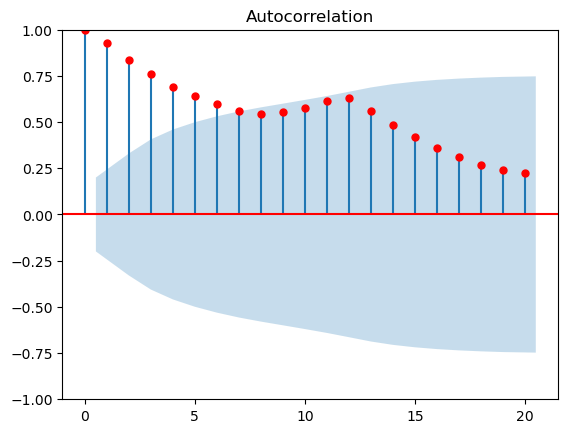

In [25]:
import statsmodels.graphics.tsaplots as tsa_plots
tsa_plots.plot_acf(airlines.Passengers,lags=12)
tsa_plots.plot_pacf(airlines.Passengers,lags=12)
tsa_plots.plot_acf(airlines.Passengers,color='r')
plt.show()

## Splitting data

In [26]:
Train=airlines.head(80)
Test = airlines.tail(12)

In [27]:
Train.head()

,Passengers,month,year,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,t,t_squared,Log_Passengers
0,112,Jan,1995,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,4.718499
1,118,Feb,1995,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,4,4.770685
2,132,Mar,1995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3,9,4.882802
3,129,Apr,1995,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,16,4.859812
4,121,May,1995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5,25,4.795791


In [28]:
Test.head()

,Passengers,month,year,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,t,t_squared,Log_Passengers
84,284,Jan,2002,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,85,7225,5.648974
85,277,Feb,2002,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,86,7396,5.624018
86,317,Mar,2002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,87,7569,5.758902
87,313,Apr,2002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88,7744,5.746203
88,318,May,2002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,89,7921,5.762051


In [29]:
#Linear Model
import statsmodels.formula.api as smf 

linear_model = smf.ols('Passengers~t',data=Train).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(Test['t'])))
rmse_linear = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_linear))**2))
rmse_linear

52.16108226512826

In [30]:
#Exponential

Exp = smf.ols('Log_Passengers~t',data=Train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(Test['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(np.exp(pred_Exp)))**2))
rmse_Exp


45.697533047918846

In [31]:
#Quadratic
quad= smf.ols('Passengers~t+t_squared',data=Train).fit()
pred_quad=pd.Series(quad.predict(pd.DataFrame(Test[['t','t_squared']])))
rmse_quad=np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_quad))**2))
rmse_quad

45.603055272917175

In [32]:
#Additive Seasonality
add_sea = smf.ols('Passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data=Train).fit()
pred_add_sea = pd.Series(add_sea.predict(Test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov']]))
rmse_add_sea = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_add_sea))**2))
rmse_add_sea

137.38569683837986

In [33]:
# Additive Seasonality quadrative

add_sea_Quad = smf.ols('Passengers~t+t_squared+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data=Train).fit()
pred_add_sea_quad=pd.Series(add_sea_Quad.predict(Test[['t','t_squared','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_add_sea_quad))**2))
rmse_add_sea_quad

26.798376686225506

In [34]:
#Multiplicative Seasonality

Mul_sea = smf.ols('Log_Passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data = Train).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(Test))
rmse_Mult_sea = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(np.exp(pred_Mult_sea)))**2))
rmse_Mult_sea

143.88334727021285

In [35]:
#Multiplicative addditive seasonality

Mul_Add_sea = smf.ols('Log_Passengers~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data = Train).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(Test))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(np.exp(pred_Mult_add_sea)))**2))
rmse_Mult_add_sea 

10.67414022302867

In [36]:
data = {"MODEL":pd.Series(["rmse_linear","rmse_Exp","rmse_quad","rmse_add_sea","rmse_add_sea_quad","rmse_Mult_sea","rmse_Mult_add_sea"]),"RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea])}
table_rmse=pd.DataFrame(data)
table_rmse

,MODEL,RMSE_Values
0,rmse_linear,52.161082
1,rmse_Exp,45.697533
2,rmse_quad,45.603055
3,rmse_add_sea,137.385697
4,rmse_add_sea_quad,26.798377
5,rmse_Mult_sea,143.883347
6,rmse_Mult_add_sea,10.674140


## Evaluation Metric

In [37]:
def MAPE(pred,org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)

## Simple Exponential Method

In [38]:
ses_model = SimpleExpSmoothing(Train["Passengers"]).fit(smoothing_level=0.2)
pred_ses = ses_model.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_ses,Test.Passengers) 

11.35850786827716

## Holt method

In [39]:
# Holt method 
hw_model = Holt(Train["Passengers"]).fit(smoothing_level=0.8, smoothing_slope=0.2)
pred_hw = hw_model.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hw,Test.Passengers) 

55.08540007468639

### holts winter exponential smoothing with additive seasonality and additive trend

In [40]:
hwe_model_add_add = ExponentialSmoothing(Train["Passengers"],seasonal="add",trend="add",seasonal_periods=12).fit() #add the trend to the model
pred_hwe_add_add = hwe_model_add_add.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hwe_add_add,Test.Passengers) 

7.0912660401740295

### Holts winter exponential smoothing with multiplicative seasonality and additive trend

In [41]:
hwe_model_mul_add = ExponentialSmoothing(Train["Passengers"],seasonal="mul",trend="add",seasonal_periods=12).fit() 
pred_hwe_mul_add = hwe_model_mul_add.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hwe_mul_add,Test.Passengers)

3.9242011293385186

### final Model by combining train and test

In [42]:
hwe_model_mul_add = ExponentialSmoothing(airlines["Passengers"],seasonal="mul",trend="add",seasonal_periods=12).fit() 

In [53]:
#Forecasting for next 10 time period
forecast=pd.Series(hwe_model_mul_add.forecast(10))

In [54]:
forecast

96     312.900533
97     308.172851
98     355.534843
99     345.772161
100    345.698761
101    392.473944
102    436.505077
103    429.863114
104    380.176787
105    332.321235
dtype: float64

## Observation

##### Holts winter exponential smoothing with multiplicative seasonality and additive trend gives the best Mape